## Photo Classification by genre
#### Assignment datas:
###### Name: Sándor Balázs
###### Neptun ID: AZA6NL
###### Network: ResNet18
###### Objects: PhotoDB

### GitHub repository for the assignment:
https://github.com/SandorBalazsHU/elte-ik-kutmod
### The own dataset:
https://drive.google.com/drive/folders/1tI_4lpFtdm3cvkHvUJw7WzLzZ1Wb7iIp?usp=sharing

## 0. Runtime environment
I ran the project on my own computer in my own environment built using python venv using CUDA.

In [18]:
# python -m venv venv
# venv\Scripts\activate
# pip install numpy
# pip install torch==2.1.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html
# pip install torchvision
# pip install torchsummary
# pip install pandas
# pip install jupyter
# pip install graphviz
# pip install matplotlib
# pip install IPython
# pip install sklearn
# pip install seaborn
# pip install pretty_confusion_matrix

# jupyter notebook

In [1]:
!nvidia-smi

Wed Dec  6 00:59:20 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.17                 Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   37C    P8               3W /  50W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Import libraries
Import all libraries/packages and initialize the device. (CUDA in tis case)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler # customize the training
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import warnings
warnings.filterwarnings("ignore") 

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.zeros(1).cuda()

True
cuda:0


tensor([0.], device='cuda:0')

## 2. Dataset
Loading the dataset, split it and introduce it.

### The dataset's structure.
My dataset created by me from my own photo library. I chose some photos from my phot library and i categorized them by 16 genre, i wrote a script wich can convert the Nikon raw .nef format to .jpg and resize the images to 224 with for the ResNet. Then i wrote a script wich rename the images and an another wich split the images to training, test and validation set (50-25-25).

The used scripts are available in the project repository.

The selected classes:

aircraft_in_air, aircraft_on_ground, animal, architecture, astro, fireworks, forest, interior, item, landscape, macro, music, nature, people, street, vehicle

The used dataset sizes:

train: 4246

validation: 2119

test: 213    

### Batch size
I have a 4GB GPU, for this size the 64 batch seemed size is ideal for two modells and a correct running time.

### Image transformation
Because the ResNet18 model is designed for images of size 224, I scale it to that size and then do random transformations.

### Pre-processing the dataset (data loader with transformations)

In [3]:
Batch_size=64;

#Size 224 is ideal for ResNet18
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=(5, 50), translate=(0.1, 0.3), scale=(0.9, 1.1)),
        transforms.RandomPerspective(distortion_scale=0.2),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=Batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print("Readed classes: ")
print(class_names)
print("Readed dataset sizes: ")
print(dataset_sizes)

Readed classes: 
['aircraft_in_air', 'aircraft_on_ground', 'animal', 'architecture', 'astro', 'fireworks', 'forest', 'interior', 'item', 'landscape', 'macro', 'music', 'nature', 'people', 'street', 'vehicle']
Readed dataset sizes: 
{'train': 4246, 'val': 2119, 'test': 2135}


### Showing some images and labels

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

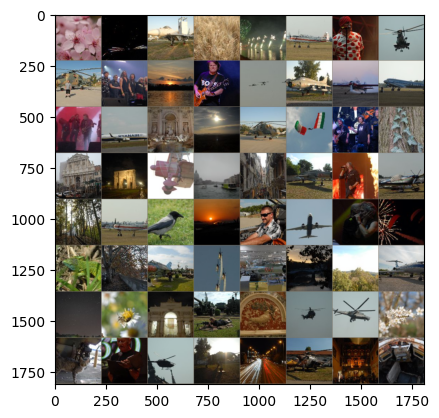

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

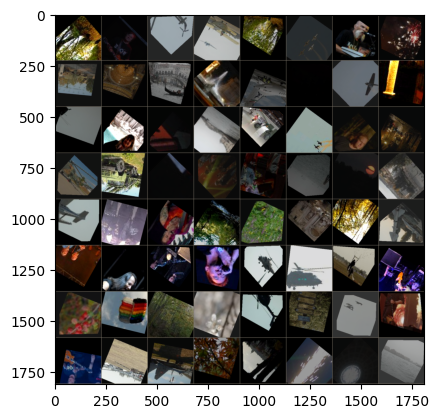

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

## 3. Convolutional Neural Network Architecture
Load the pre-trained CNN architecture you were given.

### Load the given pre-trained model

In [7]:
model = models.resnet18()

#### Summary of the given pre-trained model

ResNet18 Architecture

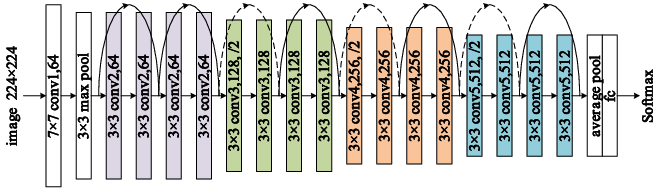

In [8]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Create the model trainer method.

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_acc_h=[]
    train_acc_h=[]
    for epoch in range(num_epochs):
      
            
        print('Epoch {}/{} LR {:.6f}'.format(epoch, num_epochs - 1, scheduler.get_last_lr()[0]))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_acc_h.append(epoch_acc)
            # deep copy the model
            if phase == 'val':
                val_acc_h.append(epoch_acc)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                

        print('Test started')
    phase == 'test'
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        test_loss = running_loss / dataset_sizes[phase]
        test_acc = running_corrects.double() / dataset_sizes[phase]
        
    time_elapsed = time.time() - since
    print('Training and testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Test Acc: {:4f}'.format(test_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_h, train_acc_h, test_acc

### Build the basic model.

In [10]:
#Random weights for the modell
model = models.resnet18()
numrs = model.fc.in_features

model.fc = nn.Linear(numrs, len(class_names))
model = model.to(device)

#CrossEntropyLoss loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Run the training

In [11]:
model, val_acc_h, train_acc_h, test_acc = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9 LR 0.000100
----------
train Loss: 1.8947 Acc: 0.4187
val Loss: 1.5985 Acc: 0.5399
Test started
Epoch 1/9 LR 0.000100
----------
train Loss: 1.5402 Acc: 0.5188
val Loss: 1.3821 Acc: 0.6159
Test started
Epoch 2/9 LR 0.000100
----------
train Loss: 1.4325 Acc: 0.5400
val Loss: 1.2169 Acc: 0.6083
Test started
Epoch 3/9 LR 0.000100
----------
train Loss: 1.3479 Acc: 0.5678
val Loss: 1.2907 Acc: 0.6074
Test started
Epoch 4/9 LR 0.000100
----------
train Loss: 1.2964 Acc: 0.5888
val Loss: 1.1421 Acc: 0.6413
Test started
Epoch 5/9 LR 0.000100
----------
train Loss: 1.2245 Acc: 0.6180
val Loss: 1.2426 Acc: 0.6154
Test started
Epoch 6/9 LR 0.000100
----------
train Loss: 1.2015 Acc: 0.6140
val Loss: 1.1757 Acc: 0.6484
Test started
Epoch 7/9 LR 0.000010
----------
train Loss: 1.1308 Acc: 0.6300
val Loss: 0.8462 Acc: 0.7442
Test started
Epoch 8/9 LR 0.000010
----------
train Loss: 1.0562 Acc: 0.6656
val Loss: 0.8319 Acc: 0.7456
Test started
Epoch 9/9 LR 0.000010
----------
train Loss: 1

### Plot the training resoults

In [14]:
def plot_acc(train_acc_h,val_acc_h, test_acc): 
    plt.figure(figsize=(10,6))
    plt.xlabel('Iteration')
    plt.ylabel('Acc')
    plt.title('Acc by Iteration')
    plt.plot(torch.tensor(train_acc_h, device = 'cpu')*100)
    plt.plot(torch.tensor(val_acc_h, device = 'cpu')*100)
    plt.plot(torch.tensor(test_acc, device = 'cpu')*100*np.ones(len(val_acc_h)))
    plt.ylim((50,100))
    plt.legend(['train', 'valid', 'test'])

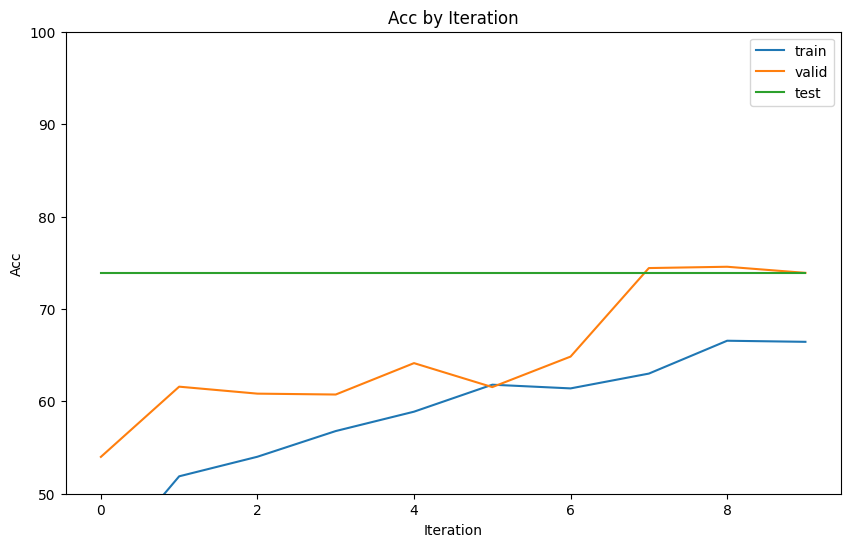

In [13]:
plot_acc(train_acc_h,val_acc_h, test_acc)

### Visualize some resoults

In [16]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                fig = plt.figure(figsize=(10,10))
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

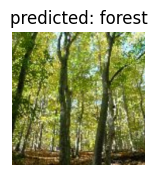

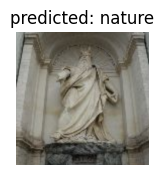

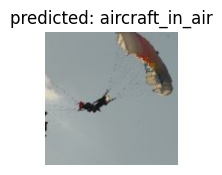

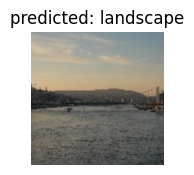

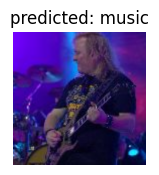

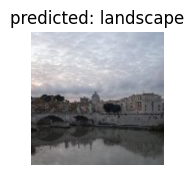

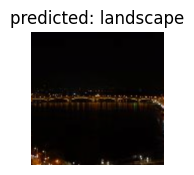

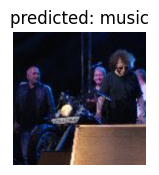

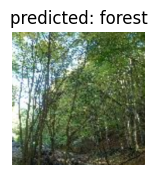

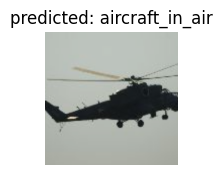

In [15]:
visualize_model(model)

#### 4. Implement the new architecture with less parameter

### The finetuned modell

In [11]:
#Pretrained from ImageNet.
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

#Same loss function
criterion = nn.CrossEntropyLoss() # BinaryCrossEntropyLoss

#SGD OPTIMIZER
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Run the learning

In [12]:
model_ft, val_acc_h, train_acc_h, test_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9 LR 0.001000
----------
train Loss: 1.8818 Acc: 0.4560
val Loss: 1.1228 Acc: 0.7046
Test started
Epoch 1/9 LR 0.001000
----------
train Loss: 1.1261 Acc: 0.6675
val Loss: 0.7735 Acc: 0.7952
Test started
Epoch 2/9 LR 0.001000
----------
train Loss: 0.8962 Acc: 0.7322
val Loss: 0.6055 Acc: 0.8268
Test started
Epoch 3/9 LR 0.001000
----------
train Loss: 0.7891 Acc: 0.7600
val Loss: 0.5196 Acc: 0.8499
Test started
Epoch 4/9 LR 0.001000
----------
train Loss: 0.7155 Acc: 0.7800
val Loss: 0.4884 Acc: 0.8542
Test started
Epoch 5/9 LR 0.001000
----------
train Loss: 0.6799 Acc: 0.7906
val Loss: 0.4341 Acc: 0.8664
Test started
Epoch 6/9 LR 0.001000
----------
train Loss: 0.6405 Acc: 0.8085
val Loss: 0.4207 Acc: 0.8726
Test started
Epoch 7/9 LR 0.000100
----------
train Loss: 0.5912 Acc: 0.8151
val Loss: 0.4038 Acc: 0.8745
Test started
Epoch 8/9 LR 0.000100
----------
train Loss: 0.5678 Acc: 0.8264
val Loss: 0.3961 Acc: 0.8759
Test started
Epoch 9/9 LR 0.000100
----------
train Loss: 0

### Plot the new accurency. It is better? YES!

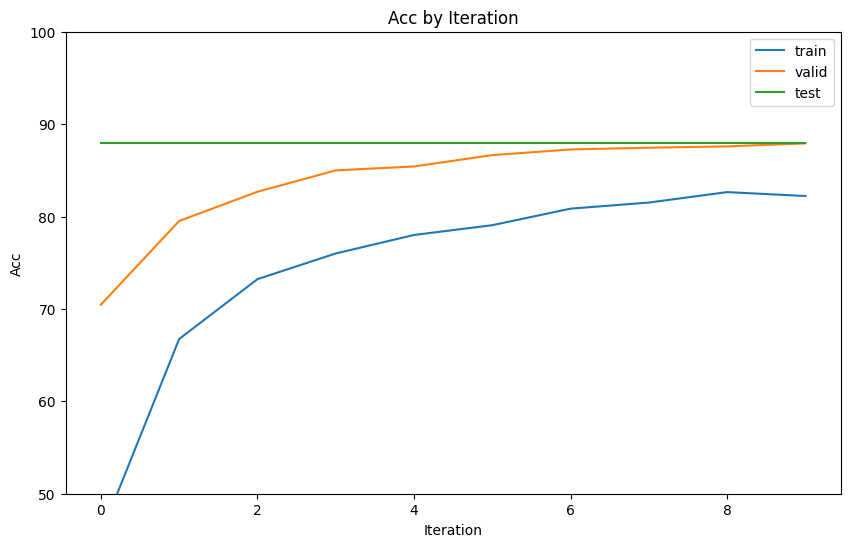

In [15]:
plot_acc(train_acc_h,val_acc_h, test_acc)

### Show some resoults.

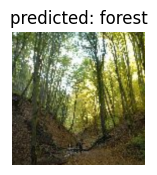

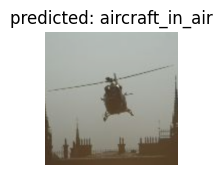

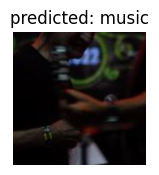

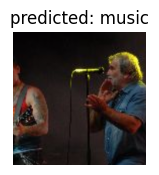

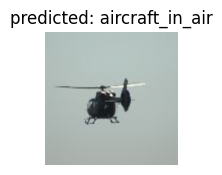

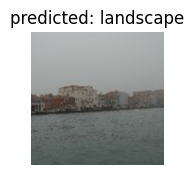

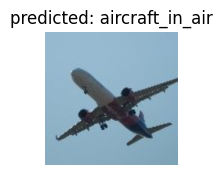

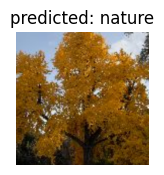

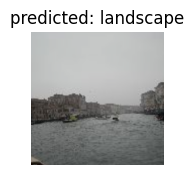

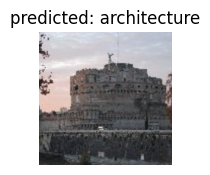

In [17]:
visualize_model(model_ft)

## 5. Final
### The fine tuned modell was better